<a href="https://colab.research.google.com/github/smahesh2694/NEU_XAI/blob/master/xai_tl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# !pip install -q xlrd

In [0]:
 #!git clone https://smahesh2694:@github.com/smahesh2694/NEU_CLS-64.git

In [17]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [18]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import pandas as pd
import numpy as np
import os
import keras
import cv2
import matplotlib.pyplot as plt
from keras.layers.core import Dense
from keras.layers import GlobalAveragePooling2D
from keras.applications import MobileNet
from keras.preprocessing import image
from keras.applications.mobilenet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model, load_model
from keras.optimizers import Adam,SGD


When loading a given model, the “include_top” argument can be set to False, in which case the fully-connected output layers of the model used to make predictions is not loaded, allowing a new output layer to be added and trained

In [21]:
base_model=MobileNet(weights='imagenet',include_top=False)  #input_shape= (200, 200, 3)

/usr/local/lib/python3.6/dist-packages/keras_applications/mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


In [0]:
x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(512,activation='relu')(x) 
preds=Dense(6,activation='softmax')(x)

In [0]:
model=Model(inputs=base_model.input, outputs=preds)

In [0]:
#model.summary()

We start by freezing all of the base model’s layers. We don’t want to train those layers since we are trying to leverage the knowledge learned by the network from the previous dataset (in this case ImageNet). By setting the layer.trainable=False , we are telling Keras not to update those weights during training, which is exactly what we want!

In [0]:
base_model.trainable = False 

get the validation data

In [0]:
train_datagen=ImageDataGenerator(rescale=1./255,
                                 shear_range=0.2,
                                 zoom_range=0.2,
                                 horizontal_flip=True, 
                                 validation_split=0.2)

In [0]:
bs = 16

In [27]:
train_generator=train_datagen.flow_from_directory('/content/drive/My Drive/NEU surface defect database - test split/Train',  
                                                 target_size=(200,200),     
                                                 batch_size=bs,
                                                 class_mode='categorical',                                                 
                                                 shuffle=True,
                                                 subset='training')

Found 1296 images belonging to 6 classes.


In [28]:
label_map = (train_generator.class_indices)
print(label_map)

{'Cr': 0, 'In': 1, 'PS': 2, 'Pa': 3, 'RS': 4, 'Sc': 5}


In [29]:
val_generator=train_datagen.flow_from_directory('/content/drive/My Drive/NEU surface defect database - test split/Train', 
                                                 target_size=(200,200),  
                                                 batch_size=bs,
                                                 class_mode='categorical',
                                                 shuffle=True,
                                                 subset='validation')

Found 324 images belonging to 6 classes.


In [0]:
#sgd = SGD(lr=0.01, clipvalue=0.5)
model.compile(optimizer=SGD(),loss='categorical_crossentropy',metrics=['acc'])

In [0]:
#model.summary()

In [31]:
step_size_train=train_generator.n//train_generator.batch_size
print(step_size_train)
step_size_val=val_generator.n//val_generator.batch_size
print(step_size_val)

81
20


In [0]:
initial_epochs = 25

In [33]:
history = model.fit_generator(generator=train_generator,
                   steps_per_epoch=step_size_train,
                   validation_data=val_generator,
                   validation_steps=step_size_val,                
                   epochs=initial_epochs)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/25
81/81 [==============================] - 712s 9s/step - loss: 0.3073 - acc: 0.9074 - val_loss: 0.0454 - val_acc: 0.9906
Epoch 2/25
81/81 [==============================] - 22s 278ms/step - loss: 0.0665 - acc: 0.9830 - val_loss: 0.0207 - val_acc: 0.9968
Epoch 3/25
81/81 [==============================] - 22s 274ms/step - loss: 0.0330 - acc: 0.9923 - val_loss: 0.0290 - val_acc: 0.9935
Epoch 4/25
81/81 [==============================] - 22s 270ms/step - loss: 0.0512 - acc: 0.9830 - val_loss: 0.0284 - val_acc: 0.9870
Epoch 5/25
81/81 [==============================] - 22s 271ms/step - loss: 0.0405 - acc: 0.9900 - val_loss: 0.0143 - val_acc: 0.9903
Epoch 6/25
81/81 [==============================] - 22s 269ms/step - loss: 0.0269 - acc: 0.9923 - val_loss: 0.0047 - val_acc: 1.0000
Epoch 7/25
81/81 [==============================] - 22s 268ms/step - loss: 0.0166 - acc: 0.9969 - val_loss: 

In [0]:
#print(history.history.keys())

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

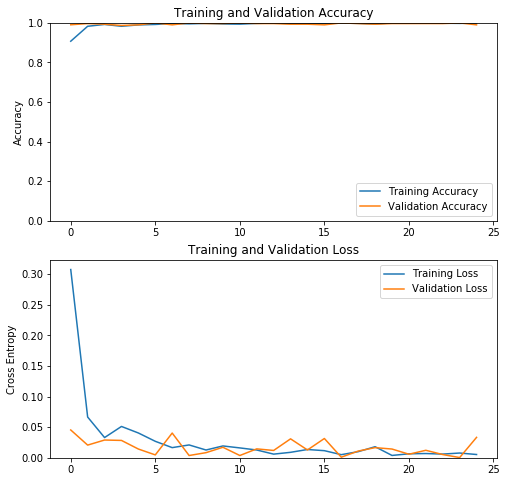

In [35]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([0,1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.savefig('/content/drive/My Drive/xai_model/MN_80_20_SGD_22.jpg')
plt.show()



In [0]:
base_model.trainable = True

In [37]:
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  87


In [0]:
fine_tune_at = 59

In [0]:
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

In [0]:
#model.compile(optimizer='sgd',loss='categorical_crossentropy',metrics=['acc'])

In [0]:
#model.summary()

In [41]:
fine_tune_epochs = 15
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit_generator(generator=train_generator,
                   steps_per_epoch=step_size_train,
                   validation_data=val_generator,
                   validation_steps=step_size_val,                
                   epochs=total_epochs,
                   initial_epoch = initial_epochs)

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch 26/40
81/81 [==============================] - 23s 290ms/step - loss: 0.0139 - acc: 0.9938 - val_loss: 0.0026 - val_acc: 1.0000
Epoch 27/40
81/81 [==============================] - 22s 277ms/step - loss: 0.0089 - acc: 0.9969 - val_loss: 0.0065 - val_acc: 0.9968
Epoch 28/40
81/81 [==============================] - 22s 270ms/step - loss: 0.0113 - acc: 0.9954 - val_loss: 0.0107 - val_acc: 0.9968
Epoch 29/40
81/81 [==============================] - 22s 273ms/step - loss: 0.0058 - acc: 0.9985 - val_loss: 0.0179 - val_acc: 0.9935
Epoch 30/40
81/81 [==============================] - 22s 270ms/step - loss: 0.0050 - acc: 0.9977 - val_loss: 0.0145 - val_acc: 0.9935
Epoch 31/40
81/81 [==============================] - 22s 270ms/step - loss: 0.0101 - acc: 0.9961 - val_loss: 0.0129 - val_acc: 0.9968
Epoch 32/40
81/81 [==============================] - 22s 271ms/step - loss: 0.0019 - acc: 1.0000 - val_loss: 0.0071 - val_acc: 0.9968
Epoch 33/40
81/81 [==============================] - 22s 269ms

In [0]:
acc += history_fine.history['acc']
val_acc += history_fine.history['val_acc']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

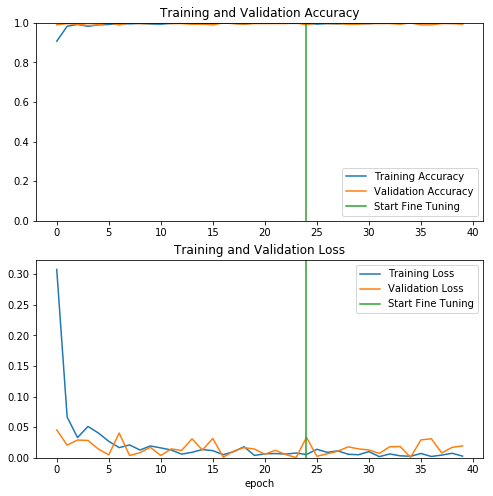

In [43]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, max(plt.ylim())])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.savefig('/content/drive/My Drive/xai_model/MN_FT_80_20_SFD_22.jpg')
plt.show()

In [0]:
#model.save('/content/drive/My Drive/xai_model/model_22.h5')

In [0]:
#model.save_weights('/content/drive/My Drive/xai_model/weights_22.h5')

Prediction on model 20

In [0]:
#saved_model = load_model('/content/drive/My Drive/xai_model/model.h5')

In [0]:
#saved_model.layers[0].input_shape

In [0]:
#saved_model.summary()

In [0]:
#model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['acc'])

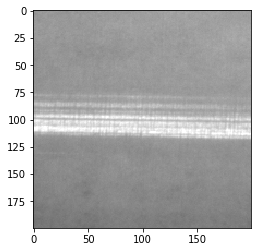

In [0]:
image_path="/content/drive/My Drive/xai_test/Sc_59.bmp"
img = image.load_img(image_path, target_size=(200,200))
plt.imshow(img)

In [0]:
img = image.img_to_array(img)
img = np.expand_dims(img, axis=0)
img = preprocess_input(img)
result = model.predict(img)
print(result)

[[4.8021575e-05 1.5451562e-06 3.0087494e-05 1.4551361e-03 4.6496496e-07
  9.9846470e-01]]


In [0]:
prediction = result.argmax(axis=-1)
print(label_map)
print(prediction)

{'Cr': 0, 'In': 1, 'PS': 2, 'Pa': 3, 'RS': 4, 'Sc': 5}
[5]


In [0]:
if prediction == 0:
  label = "Crazing" 
elif prediction == 1:
  label = "Inclusion"
elif prediction == 2:
  label = "Pitted Surface"
elif prediction == 3:
  label = "Patches"
elif prediction == 4:
  label = "Rolled-in scale"
elif prediction == 5:
  label = "Sratches"
else:
  label = "Exception"

print(label)

Sratches
